# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHES = 50
LR = 0.001

In [3]:
class CHDataset(Dataset):
    def __init__(self, *init_datasets):
        assert all(init_datasets[0].size(0) == init_dataset.size(0) for init_dataset in init_datasets), "Не соотвутствует размерность среди dataset"
        self._base_datasets = init_datasets
  
    def __len__(self):
        return self._base_datasets[0].size(0)
  
    def __getitem__(self, idx):
        return tuple(base_dataset[idx] for base_dataset in self._base_datasets)

In [4]:
class CHNet(nn.Module):
    def __init__(self) -> None:
        super(CHNet, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Linear(in_features=8, out_features=100, bias=True),
            nn.Dropout(0.1),
            nn.BatchNorm1d(100),
            nn.ReLU())
        self.block_2 = nn.Sequential(
            nn.Linear(in_features=100, out_features=100, bias=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(100),
            nn.ReLU())
        self.block_3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=60, bias=True),
            nn.Dropout(0.2),
            nn.BatchNorm1d(60),
            nn.ReLU())
        self.block_4 = nn.Sequential(
            nn.Linear(in_features=60, out_features=30),
            nn.Dropout(0.2),
            nn.BatchNorm1d(30),
            nn.ReLU())
        self.predict = nn.Sequential(
            nn.Linear(in_features=30, out_features=1, bias=True),
            nn.BatchNorm1d(1),
            nn.ReLU())
  
    def forward(self, inp):
        out = self.block_1(inp)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_4(out)
        out = self.predict(out)
        return out[:, 0]

In [5]:
def train_loop(train_loader, test_loader, net, optimizer):
    loss_fn = nn.MSELoss()
    best_acc = {'train': None, 'test': None}
    train_loss_all=[]
    net.train()
    for epoch in range(EPOCHES):
        train_loss=0
        train_num=0
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            
            # обнуляем градиент
            optimizer.zero_grad()
            
            # делаем предсказание
            outputs = net(inputs)
            
            # считаем ошибку
            loss = loss_fn(outputs, labels)

            # меняем веса
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            train_loss+=loss.item()*inputs.size(0)
            train_num+=inputs.size(0)
            if i + 1 == len(train_loader) and epoch % 5 == 0:
                print(f'Epoch [{epoch + 1}/{EPOCHES}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {train_loss / train_num:.3f}')
        train_loss_all.append(train_loss / train_num)
    
    return train_loss_all

In [6]:
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        #Определить первый скрытый слой
        self.hidden1=nn.Linear(in_features=8,out_features=100,bias=True)#8*100 8 Особенности атрибута
        #Определить второй скрытый слой
        self.hidden2=nn.Linear(100,100)#100*100
        #Определить третий скрытый слой
        self.hidden3=nn.Linear(100,50)#100*50
        # -Регрессия прогноз слой
        self.predict=nn.Linear(50,1)#50*1 Прогноз только на одну цену дома
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=F.relu(self.hidden2(x))
        x=F.relu(self.hidden3(x))
        output=self.predict(x)
        return output[:,0]
mlpreg=MLPregression()

In [7]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [8]:
california_housing = fetch_california_housing()
# Разделим на тестовые и тренеровочные данные
X_train, X_test, y_train, y_test = train_test_split(california_housing.data, california_housing.target, test_size=0.25, random_state=13)

In [9]:
# Нормализуем данные и подготовим их для дальнейшего использования в нашем dstaset
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)

In [10]:
train_xt = torch.from_numpy(X_train_s.astype(np.float32)).to(DEVICE)
train_yt = torch.from_numpy(y_train.astype(np.float32)).to(DEVICE)

test_xt = torch.from_numpy(X_test_s.astype(np.float32)).to(DEVICE)
test_yt = torch.from_numpy(y_test.astype(np.float32)).to(DEVICE)

In [11]:
train_dataset = CHDataset(train_xt, train_yt)
test_dataset = CHDataset(test_xt, test_yt)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=False)

In [13]:
result = {}

# Adam

In [14]:
net = CHNet().to(DEVICE)
optimizer = Adam(net.parameters(), lr=LR)

In [15]:
%%time
result['adam'] = train_loop(train_loader, test_loader, net, optimizer)

Epoch [1/50]. Step [242/242]. Loss: 3.074
Epoch [6/50]. Step [242/242]. Loss: 0.767
Epoch [11/50]. Step [242/242]. Loss: 0.477
Epoch [16/50]. Step [242/242]. Loss: 0.425
Epoch [21/50]. Step [242/242]. Loss: 0.412
Epoch [26/50]. Step [242/242]. Loss: 0.396
Epoch [31/50]. Step [242/242]. Loss: 0.384
Epoch [36/50]. Step [242/242]. Loss: 0.377
Epoch [41/50]. Step [242/242]. Loss: 0.371
Epoch [46/50]. Step [242/242]. Loss: 0.365
CPU times: total: 6min 29s
Wall time: 1min 5s


# RMSProp

In [16]:
net = CHNet().to(DEVICE)
optimizer = RMSprop(net.parameters(), lr=LR)

In [17]:
%%time
result['rms'] = train_loop(train_loader, test_loader, net, optimizer)

Epoch [1/50]. Step [242/242]. Loss: 2.670
Epoch [6/50]. Step [242/242]. Loss: 0.607
Epoch [11/50]. Step [242/242]. Loss: 0.451
Epoch [16/50]. Step [242/242]. Loss: 0.413
Epoch [21/50]. Step [242/242]. Loss: 0.398
Epoch [26/50]. Step [242/242]. Loss: 0.397
Epoch [31/50]. Step [242/242]. Loss: 0.380
Epoch [36/50]. Step [242/242]. Loss: 0.378
Epoch [41/50]. Step [242/242]. Loss: 0.364
Epoch [46/50]. Step [242/242]. Loss: 0.360
CPU times: total: 5min 52s
Wall time: 59 s


# SGD

In [18]:
net = CHNet().to(DEVICE)
optimizer = SGD(net.parameters(), lr=LR)

In [19]:
%%time
result['sgd'] = train_loop(train_loader, test_loader, net, optimizer)

Epoch [1/50]. Step [242/242]. Loss: 3.389
Epoch [6/50]. Step [242/242]. Loss: 0.819
Epoch [11/50]. Step [242/242]. Loss: 0.699
Epoch [16/50]. Step [242/242]. Loss: 0.649
Epoch [21/50]. Step [242/242]. Loss: 0.615
Epoch [26/50]. Step [242/242]. Loss: 0.581
Epoch [31/50]. Step [242/242]. Loss: 0.534
Epoch [36/50]. Step [242/242]. Loss: 0.509
Epoch [41/50]. Step [242/242]. Loss: 0.495
Epoch [46/50]. Step [242/242]. Loss: 0.499
CPU times: total: 5min 25s
Wall time: 54.7 s


# SGD + Momentum

In [20]:
net = CHNet().to(DEVICE)
optimizer = SGD(net.parameters(), lr=LR, momentum=0.8)

In [21]:
%%time
result['sgdm'] = train_loop(train_loader, test_loader, net, optimizer)

Epoch [1/50]. Step [242/242]. Loss: 1.876
Epoch [6/50]. Step [242/242]. Loss: 0.554
Epoch [11/50]. Step [242/242]. Loss: 0.476
Epoch [16/50]. Step [242/242]. Loss: 0.452
Epoch [21/50]. Step [242/242]. Loss: 0.426
Epoch [26/50]. Step [242/242]. Loss: 0.408
Epoch [31/50]. Step [242/242]. Loss: 0.409
Epoch [36/50]. Step [242/242]. Loss: 0.403
Epoch [41/50]. Step [242/242]. Loss: 0.402
Epoch [46/50]. Step [242/242]. Loss: 0.399
CPU times: total: 5min 29s
Wall time: 55.1 s


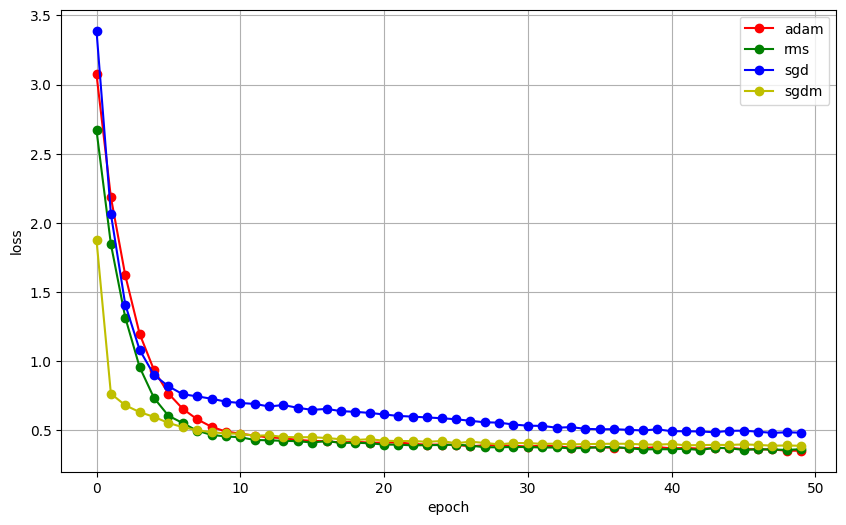

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(result['adam'], "ro-", label="adam")
plt.plot(result['rms'], "go-", label="rms")
plt.plot(result['sgd'], "bo-", label="sgd")
plt.plot(result['sgdm'], "yo-", label="sgdm")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

*Быстрее обучилась модель с оптимизатором SGD + Momentum, но меньший loss получился у модели с оптимизатором Adam*